# Neural Style Transfer

We'll describe an implementation of DeepDream.

In [1]:
import sys
sys.path.insert(0, "../../../")

## Load Data

We'll load the example image of the Drosophila ssTEM dataset from https://figshare.com/articles/dataset/Segmented_anisotropic_ssTEM_dataset_of_neural_tissue/856713. Alternatively, you can download an image from the corresponding GiHub repository: http://github.com/unidesigner/groundtruth-drosophila-vnc.

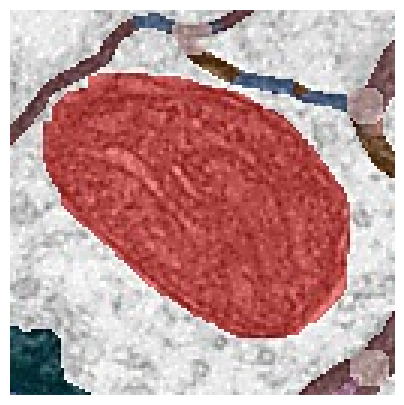

In [2]:
from PIL import Image
from urllib.request import urlopen
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

image_size = (128, 128)

url = 'https://s3-eu-west-1.amazonaws.com/pfigshare-u-previews/1288336/preview.jpg'

width = 128
height = 128
left = 100
top = 170

im_c = Image.open(urlopen(url)).crop((left,top,left + width, top + height))#.resize(image_size)

from style_transfer import plot_example
plot_example(im_c)

We'll use the style of the _trencadis_ lizard by Antoni Gaudi  in Parc Guell (Barcelona)

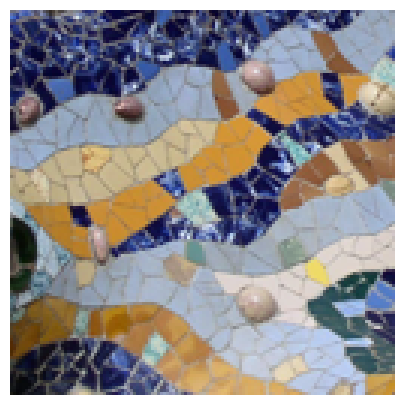

In [3]:
url = 'https://upload.wikimedia.org/wikipedia/commons/d/da/Reptil_Parc_Guell_Barcelona.jpg'

width = 512
height = 512
left = 800
top = 250

im_s = Image.open(urlopen(url)).crop((left,top,left + width, top + height)).resize(image_size)

plot_example(im_s)

In [4]:
def gram_matrix(input):
    import torch
    b, c, h, w = input.size()
    F = input.view(b,c,h*w)
    G = torch.bmm(F, F.transpose(1,2))/(h*w)
    return G

We'll download a pretrained model (VGG16).

In [5]:
import torchvision.models as models
model = models.vgg16(pretrained=True)

for param in model.features.parameters():
    param.requires_grad = False

print(model)

/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

The VGG16 is pretrained on the ImageNet dataset and the inputs are normalized wih respect to the mean and standard deviation of the channels of this dataset.

In [6]:
import numpy as np
mean_ds = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std_ds = np.array([0.229, 0.224, 0.225], dtype=np.float32)

We'll define a function that perform loss maximization through gradient ascend. 

In [7]:
# ind = [0, 2, 5, 7, 10]
# layers = [model.features[i] for i in ind ] 
# num_iterations=100
# beta = 1000

# #def style_transfer(im_c, im_s, layer_c, layer_s, beta = 10000, num_iterations=100):

# import torch
    
# from style_transfer import fwd_hooks, preprocess, deprocess, plot_dream
# import numpy as np
# from PIL import Image

# low = torch.tensor((-mean_ds / std_ds).reshape(1, -1, 1, 1))
# high = torch.tensor(((1 - mean_ds) / std_ds).reshape(1, -1, 1, 1))

# # content
# image_c = preprocess(im_c, mean_ds, std_ds)
# with fwd_hooks(layers) as fh:
#     out = model(image_c)
# content_features = fh.stored[4].detach()

# # style
# image_s = preprocess(im_s, mean_ds, std_ds)
# with fwd_hooks(layers) as fh:
#     out = model(image_s)
# style_features = fh.stored
# gram_targets = [gram_matrix(i).detach() for i in style_features]

# image_in = image_c.clone().detach().requires_grad_(True)
# optimizer = torch.optim.LBFGS([image_in], lr = 1)

# mse_loss = torch.nn.MSELoss(reduction='mean')

# model.eval()
# model.requires_grad_(False)


# for it in range(num_iterations):
#     def closure():
#         optimizer.zero_grad()

#         # content & style
#         with fwd_hooks(layers) as fh:
#             out = model(image_in)
#         content_features_in = fh.stored[4]
#         style_features_in = fh.stored
#         gram_in = [gram_matrix(i) for i in style_features_in]

#         c_loss = 0
#         for i,c in enumerate(content_features_in):
#             c_loss += mse_loss(c,content_features[i])
        
#         s_loss = 0
#         for i,g in enumerate(gram_in):
#             n_g = g.shape[1]
#             print(n_g)
#             s_loss += mse_loss(g,gram_targets[i])/n_g**2

    
#         loss = c_loss + beta*s_loss
#         loss.backward(retain_graph=True)
#         return loss

#     optimizer.step(closure)
#     image_in.data.clamp_(low, high)

#     if (it+1)%1 == 0:
#         image_out = Image.fromarray(np.uint8(np.clip(deprocess(image_in.data.clone().detach(), mean_ds, std_ds)*255,0,255)), 'RGB') 
#         plot_dream(im_c, image_out)
# #return Image.fromarray(np.uint8(np.clip(deprocess(image_c.data.clone().detach(), mean_ds, std_ds)*255,0,255)), 'RGB')

In [16]:
def style_transfer(im_c, im_s, layers, ind_c, ind_s, lr = 1, beta = 1e3, num_iterations=100):

    import torch
    from style_transfer import fwd_hooks, preprocess, deprocess, plot_dream
    import numpy as np
    from PIL import Image

    low = torch.tensor((-mean_ds / std_ds).reshape(1, -1, 1, 1))
    high = torch.tensor(((1 - mean_ds) / std_ds).reshape(1, -1, 1, 1))

    # content
    image_c = preprocess(im_c, mean_ds, std_ds)
    with fwd_hooks(layers) as fh:
        out = model(image_c)
    content_features = [fh.stored[i].detach() for i in ind_c]

    # style
    image_s = preprocess(im_s, mean_ds, std_ds)
    with fwd_hooks(layers) as fh:
        out = model(image_s)
    style_features = [fh.stored[i].detach() for i in ind_s]
    gram_targets = [gram_matrix(s) for s in style_features]

    #input
    imarray = np.random.rand(*image_size,3) * 255
    im_in = Image.fromarray(imarray.astype('uint8')).convert('RGB')
    image_in = preprocess(im_in, mean_ds, std_ds).requires_grad_(True)

    #image_in = image_c.clone().detach().requires_grad_(True)
    optimizer = torch.optim.LBFGS([image_in], lr = lr)

    mse_loss = torch.nn.MSELoss(reduction='sum')

    model.eval()
    model.requires_grad_(False)

    l_c = []
    l_s = []

    for it in range(num_iterations):
        def closure():
            optimizer.zero_grad()

            # content & style
            with fwd_hooks(layers) as fh:
                out = model(image_in)
            content_features_in = [fh.stored[i] for i in ind_c]
            style_features_in = [fh.stored[i] for i in ind_s]
            gram_in = [gram_matrix(i) for i in style_features_in]

            c_loss = 0
            for i,c in enumerate(content_features_in):
                c_loss += mse_loss(c,content_features[i])
            c_loss /= len(content_features_in)

            s_loss = 0
            for i,g in enumerate(gram_in):
                # n_g = g.shape[1]
                s_loss += mse_loss(g,gram_targets[i])#/n_g**2
            s_loss /= len(gram_in)

            loss = c_loss + beta*s_loss
            l_c.append(c_loss)
            l_s.append(s_loss)

            loss.backward()#retain_graph=True)
            return loss

        optimizer.step(closure)
        print('Step {}: Content: {:.8f} Style: {:.8f}'.format(it, l_c[-1], l_s[-1]))


        image_in.data.clamp_(low, high)
        if (it+1)%10 == 0:
            im_out = Image.fromarray(np.uint8(np.clip(deprocess(image_in.data.clone().detach(), mean_ds, std_ds)*255,0,255)), 'RGB') 
            plot_dream(im_c, im_out)
    return Image.fromarray(np.uint8(np.clip(deprocess(image_in.data.clone().detach(), mean_ds, std_ds)*255,0,255)), 'RGB')

We'll apply deepdreams to the image, using as output the activations of the first ReLU.

Step 0: Content: 21.86452866 Style: 17.62863541
Step 1: Content: 33.92323303 Style: 2.94719529
Step 2: Content: 35.56559372 Style: 1.27261770
Step 3: Content: 36.29960632 Style: 0.69915128
Step 4: Content: 36.69203186 Style: 0.44359827
Step 5: Content: 36.31942749 Style: 0.31135553
Step 6: Content: 36.18450546 Style: 0.26023433
Step 7: Content: 36.15381622 Style: 0.19201276
Step 8: Content: 35.88664627 Style: 0.14982998
Step 9: Content: 35.34584045 Style: 0.14289744


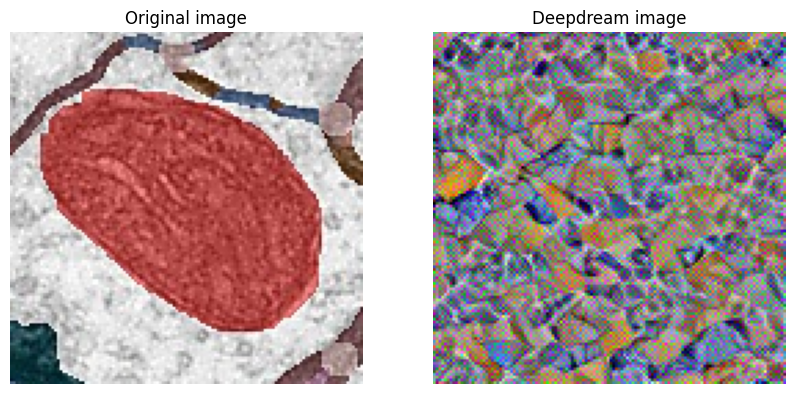

Step 10: Content: 35.73123550 Style: 0.12673548
Step 11: Content: 35.25114441 Style: 0.10312648
Step 12: Content: 34.92165375 Style: 0.09010595


KeyboardInterrupt: 

In [17]:
ind = [0, 2, 5, 7, 10, 14]#  [0, 2, 5, 7, 10]#     [0, 5, 10, 19, 21, 28]#vgg19    # [0, 5, 10, 17, 24, 26]  #
layers = [model.features[i] for i in ind ] 
# num_iterations=100
# beta = 1000
ind_c = [5]
ind_s = [0,1,2,3,4]

im_out  =  style_transfer(im_c, im_s, layers, ind_c, ind_s, lr = 0.1, beta = 1e3, num_iterations=100)